# Analyzing npSF using the principles of Information Bottleneck (Simulation 1)

In this notebook we take a look into the dynamics of npSF using the IB, reproducing some of the experiments in [1].

## Setup

We start by importing some libraries:

In [1]:
import numpy as np
import joblib
import sklearn.datasets as ds
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress

import tfSF
import npSF

import data.data_creation as D
from IT import IT

We define the parameters of our simulation:

In [2]:
learned_features = 2
n_epochs = 200

IT_bins=30

We define a couple of helper functions: a simple linear regression function and a helper function to compute the tfSF learned representation as a function of the weights.

In [3]:
def linreg(x,y):
    a, b, _, _, _ = stats.linregress(x,y)
    return a*x+b
    

def computeZ(X,W):
    WX = np.dot(W,X.T)
    F = npSF.softabsolute(WX)
    Fsquish, _ = npSF.l2row(F)
    Fhat, _ = npSF.l2row(Fsquish.T)
    Z = Fhat
    return Z

## Simulation 1 from [1]

We now reproduce the results for *Simulation 1* in [1]

### Single model

We start by considering a single model.

We generate random data.

In [4]:
data = D.get_samples_independent_gaussians_2D(n_samples_train=900, n_samples_test=100, 
                                         mu1 = 0.0, sigma1 = .5, mu2 = 0.0, sigma2 =.5)

We train the SF module.

In [5]:
npsf = npSF.SFilter()
npsf.setFeatures(learned_features)
npsf.setTrainData(data['X_tr'])
npsf.initializeWeights()
npsf.initialiazeNotebook()
npsf.train()

We plot the loss function to verify that the model converged to a solution.

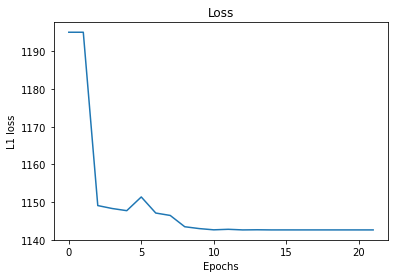

In [6]:
plt.title('Loss'); 
plt.xlabel('Epochs'); 
plt.ylabel('L1 loss');
    
plt.plot(npsf.notebook['losses'])

We compute the information-theoretic statistics of interest (entropy and mutual information) at each iteration.

In [7]:
Ws = npsf.notebook['weights']

Z_tes = []
MI_XZs = []
H_Zs = []
  
for W in Ws:
    Z_te = computeZ(data['X_te'],W)
    
    Z_tes.append(Z_te)
    MI_XZs.append(IT.compute_MI_dd_bin(data['X_te'],Z_te,n_bins=IT_bins))
    H_Zs.append(IT.compute_H_bin(Z_te,n_bins=IT_bins))

We plot entropy and mutual information.

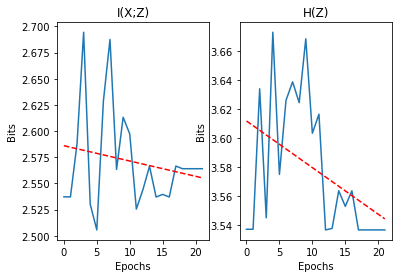

In [8]:
_,ax = plt.subplots(1,2)

ax[0].plot(MI_XZs)
ax[0].set_title('I(X;Z)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Bits')
ax[0].plot(linreg(np.arange(len(MI_XZs)),MI_XZs),'r--')

ax[1].plot(H_Zs)
ax[1].set_title('H(Z)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Bits')
ax[1].plot(linreg(np.arange(len(H_Zs)),H_Zs),'r--')

And the information graph.

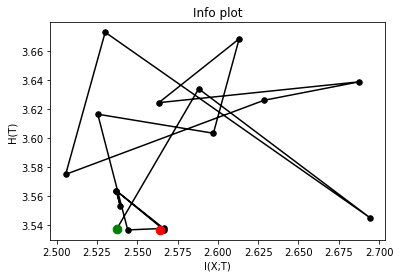

In [9]:
plt.title('Info plot'); 
plt.xlabel('I(X;T)'); 
plt.ylabel('H(T)');
    
plt.plot(MI_XZs,H_Zs,c='black', zorder=0)
plt.scatter(MI_XZs[1:-1],H_Zs[1:-1],c='black',s=30, zorder=1)
plt.scatter(MI_XZs[0],H_Zs[0],c='green',s=75,zorder=2)
plt.scatter(MI_XZs[-1],H_Zs[-1],c='red',s=75,zorder=2)

### Multiple models

We try to verify our results across multiple models.

In [10]:
n_simulations = 25

results = np.zeros((n_simulations,n_epochs,2))
for i in tqdm(range(n_simulations)):
    data = D.get_samples_independent_gaussians_2D(n_samples_train=900, n_samples_test=100, 
                                         mu1 = 0.0, sigma1 = .5, mu2 = 0.0, sigma2 =.5)
    
    npsf = npSF.SFilter()
    npsf.setFeatures(learned_features)
    npsf.setTrainData(data['X_tr'])
    npsf.initializeWeights()
    npsf.initialiazeNotebook()
    npsf.train()
    
    Ws = npsf.notebook['weights']

    for j,W in enumerate(Ws):
        Z_te = computeZ(data['X_te'],W)
    
        results[i,j,0] = IT.compute_MI_dd_bin(data['X_te'],Z_te,n_bins=IT_bins)
        results[i,j,1] = IT.compute_H_bin(Z_te,n_bins=IT_bins)


100%|██████████| 25/25 [00:02<00:00,  8.80it/s]


We then plot all the models for visual inspection.

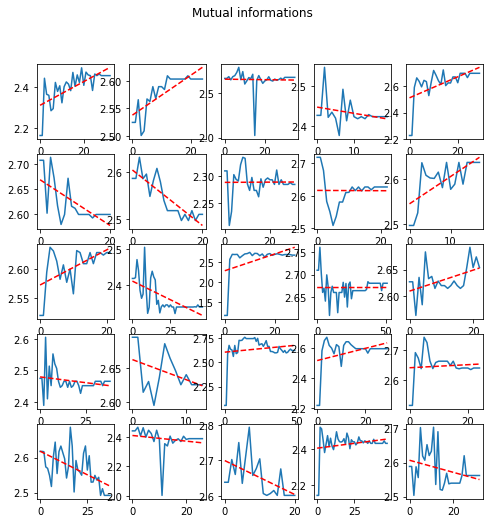

In [11]:
fig,ax = plt.subplots(5,5, figsize=(8,8))
fig.suptitle('Mutual informations')

for i in range(n_simulations):
    ax[i//5,i%5].plot(results[i,:,0][results[i,:,0] != 0])
    ax[i//5,i%5].plot(linreg(np.arange(len(results[i,:,0][results[i,:,0] != 0])),results[i,:,0][results[i,:,0] != 0]),'r--')

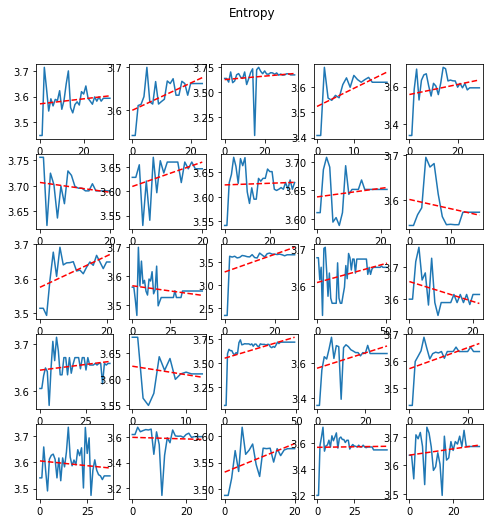

In [12]:
fig,ax = plt.subplots(5,5, figsize=(8,8))
fig.suptitle('Entropy')

for i in range(n_simulations):
    ax[i//5,i%5].plot(results[i,:,1][results[i,:,1] != 0])
    ax[i//5,i%5].plot(linreg(np.arange(len(results[i,:,1][results[i,:,1] != 0])),results[i,:,1][results[i,:,1] != 0]),'r--')

### Averaging models

We now aggregate all the simulation to evaluate the ensemble dynamics.

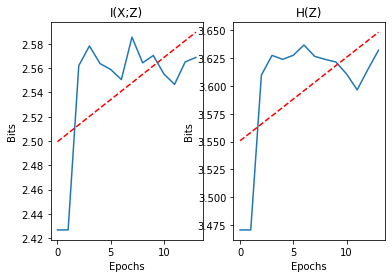

In [13]:
actualepochs = []
for i in range(n_simulations):
    a = results[i,:,0][results[i,:,0]!=0]
    actualepochs.append(a.shape[0])

finalepoch = np.min(actualepochs)

avgMI = np.mean(results[:,0:finalepoch,0],axis=0)
avgH = np.mean(results[:,0:finalepoch,1],axis=0)

_,ax = plt.subplots(1,2)

ax[0].plot(avgMI)
ax[0].set_title('I(X;Z)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Bits')
ax[0].plot(linreg(np.arange(len(avgMI)),avgMI),'r--')

ax[1].plot(avgH)
ax[1].set_title('H(Z)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Bits')
ax[1].plot(linreg(np.arange(len(avgH)),avgH),'r--')

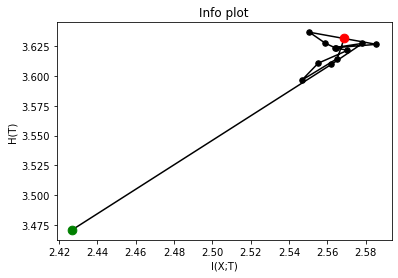

In [14]:
plt.title('Info plot'); 
plt.xlabel('I(X;T)'); 
plt.ylabel('H(T)');

plt.plot(avgMI,avgH,c='black', zorder=0)
plt.scatter(avgMI[1:-1],avgH[1:-1],c='black',s=30, zorder=1)
plt.scatter(avgMI[0],avgH[0],c='green',s=75,zorder=2)
plt.scatter(avgMI[-1],avgH[-1],c='red',s=75,zorder=2)

### Analyzing linear slopes

We notice a mismatch between the individual dynamics of all the npSF modules (which show both increase and decrease in the IT quantities) and the ensemble dynamics (which shows a clear increasing behaviour). This may be an artifact of clipping the number of epochs over which we average.

To test this we evaluate the average linear slope.

In [15]:
MI_slopes = []
H_slopes = []

for i in range(n_simulations):
    a, b, _, _, _ = stats.linregress(np.arange(len(results[i,:,0][results[i,:,0] != 0])),results[i,:,0][results[i,:,0] != 0])
    MI_slopes.append(a)
    a, b, _, _, _ = stats.linregress(np.arange(len(results[i,:,1][results[i,:,1] != 0])),results[i,:,1][results[i,:,1] != 0])
    H_slopes.append(a)
    
print('Average slope for MI: {0}'.format(np.mean(MI_slopes)))
print('Average slope for H: {0}'.format(np.mean(H_slopes)))

Average slope for MI: 0.00107625696867717
Average slope for H: 0.0020381338214719054


We also consider the correlation between the IT quantities.

In [16]:
correlations = []

for i in range(n_simulations):
    r, _ = stats.pearsonr(results[i,:,0][results[i,:,0]!=0],results[i,:,1][results[i,:,1]!=0])
    correlations.append(r)
                                                                       
print('Average correlation: {0}'.format(np.mean(correlations)))
print('Correlations: {0}'.format(correlations))
                                                                       

Average correlation: 0.4554373077347884
Correlations: [0.6348377235305912, 0.6078376710431943, 0.8790276701576266, 0.25421588266082495, 0.8058374039986902, 0.6576990307405564, -0.3001110264415187, 0.14175944725606393, 0.08565691733104643, 0.2181982655233821, 0.5506078854017389, 0.2762578150048839, 0.9922233793246626, 0.11022396543823212, -0.10937131868527052, 0.156812916581276, 0.7768301013652656, 0.898019131040349, 0.8748464027241057, 0.8372152293083659, 0.28721476134638446, 0.901784069945609, -0.262256326170429, 0.8758754308203929, 0.23469026412368757]


## Conclusions

- Results in [1] are an artifact of epoch clipping
- Slope and correlation coefficient suggest different results

### References

[1] Zennaro, F.M. and Chen, K., 2019. Towards Further Understanding of Sparse Filtering via Information Bottleneck. arXiv preprint arXiv:1910.08964.